In [2]:
import glob
import numpy as np
import pandas as pd 
from collections import defaultdict
from math import isclose
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import random

/home/gabrihacker/.virtualenvs/truenets_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  if __name__ == "__main__":


In [2]:
runs = glob.glob('/home/gabrihacker/TNSM2022/results_rebuttal/*/*/*/*/*/*/*/')

results = []
for r in runs[:]:
    max_angles = []
    min_distances = []
    prefix, subpath = r.split('results_rebuttal')
    params =  subpath.split('/')
    sa, rf, k, ratio, dens = params[3:-1]
    bp = prefix+'results_rebuttal'+'/'.join(params[:4])
    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                        sep=' ', 
                        header=0, 
                        names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                        ).set_index('p_i')
    links = np.argwhere(viewsheds) #get ones from the viewshed
    nodes_dict = {}
    for n in nodes.index:
        pn = nodes.loc[n]
        nodes_dict[n] = np.array([pn.x, pn.y])

    #create a dict with a list of bs that sees a point
    adjdict = defaultdict(list)
    for l in links:
        ant = l[1]
        p = l[0]
        if ant in nodes.index:
            adjdict[p].append(nodes_dict[ant])

    for p in adjdict.keys():
        bs_loc = invmat[p]
        dists = []
        angles = []
        vectors = []
        for loc in adjdict[p]:
            v = loc-bs_loc
            vectors.append(v)
            dists.append(np.linalg.norm(v))
            angles.append(float(np.degrees(np.arctan2(v[0], v[1])))) #cast to int to avoid errors
        angles.sort()      
        angles.append(angles[0])  ##Trick to create a ring
        angles = np.array(angles) #convert to n[0], vector[1]umpy
        diffs = (angles[1:] - angles[:-1]) % 360  #modulo 360 to get positive  angles
        assert(isclose(sum(diffs),360) or isclose(sum(diffs),0))

        result = {}
        result['sa'] = sa
        if rf == 'r1' and k=='1':
            result['scoring'] = '1-CM'
        elif rf == 'r1' and k=='3':
            result['scoring'] = '3-CM'
        elif rf == 'rlc' and k=='3':
            result['scoring'] = '3-CG'
        elif rf == 'fi'  and k=='3':
            result['scoring'] = '3-CF'
        elif rf == 'r2' and k=='3':
            result['scoring'] = '3-CM2'
        
        result['ratio'] = float(ratio)
        result['dens'] =int(dens)
        result['max_angle'] = diffs.max()
        result['min_distance'] = np.array(dists).min(axis=0)
        result['ncov'] = len(adjdict[p])
        # result['vectors'] = vectors
        # result['angles'] = angles[:-1]

        results.append(result)

results = pd.DataFrame(results)
results.to_pickle('/home/gabrihacker/TNSM2022/results_rebuttal/postprocess')

In [15]:
results = pd.read_pickle('/home/gabrihacker/TNSM2022/results_rebuttal/postprocess')

In [ ]:

g = sns.FacetGrid(results[(results.ncov > 1) & (results.ncov <5) & (results.scoring != '3-CM2')], col="ncov",  row="scoring", sharey='row')
g.map_dataframe(sns.histplot, x='max_angle', stat='density')


Generate Synthetical Angles

In [3]:
synth_results = []
sample_size = 1000000
max_ncov=6
fig = plt.figure(figsize=(5*max_ncov,5))
for ndx, ncov in enumerate(range(2,max_ncov)):
    angles = np.random.rand(sample_size, ncov+1)*360
    angles = np.sort(angles, axis=1)
    angles[:,-1] = angles[:,0]
    diffs = (angles[:, 1:]- angles[:, :-1])%360
    max_angles = diffs.max(axis=1)
    for m in max_angles:
        result = {}
        result['scoring'] = 'Synth'
        result['sa'] = -1
        result['ratio'] = 0
        result['dens'] = 0
        result['max_angle'] = m
        result['min_distance'] = 0
        result['ncov'] = ncov
        synth_results.append(result)
    
synth_results = pd.DataFrame(synth_results)

<Figure size 2160x360 with 0 Axes>

135 2
0           False
1           False
2           False
3           False
4           False
            ...  
34336077    False
34336078    False
34336079    False
34336080    False
34336081    False
Name: ncov, Length: 34336082, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
34336077    False
34336078    False
34336079    False
34336080    False
34336081    False
Name: ncov, Length: 34336082, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
34336077    False
34336078    False
34336079    False
34336080    False
34336081    False
Name: ncov, Length: 34336082, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
34336077    False
34336078    False
34336079    False
34336080    False
34336081    False
Name: ncov, Length: 34336082, dtype: bool


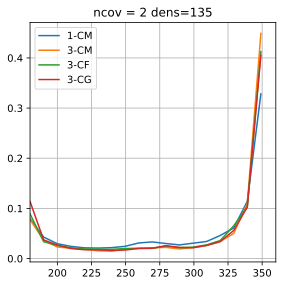

In [16]:
plt.figure(figsize=(15,15))
for ddx, dens in enumerate(sorted(map(int, results.dens.unique()[:1]))):
    for ndx, ncov in enumerate(range(2,3)):
        print(dens, ncov)
        ax = plt.subplot(3,3,1+ndx+ddx*3)
        if ncov==4: # use >=
            filter = results.ncov>=ncov
            synth_filter =  synth_results.ncov>=ncov
            ax.set_title(f'ncov >=  {ncov}dens={dens}')
        else:
            filter= results.ncov==ncov
            synth_filter =  synth_results.ncov==ncov
            ax.set_title(f'ncov = {ncov} dens={dens}')
            
        for score in results[(results.scoring != '3-CM2')].scoring.unique():
            vals = results[(filter) & (results.scoring == score)& (results.dens==dens)].max_angle
            y, bins = np.histogram(vals, bins=18, range=(360/ncov,359))
            y=y/sum(y)
            ax.plot(bins[:-1], y, label=score)
        
        vals = synth_results[(filter)].max_angle
        y, bins = np.histogram(vals, bins=18, range=(360/ncov,359))
        y=y/sum(y)
        ax.plot(bins[:-1], y, label='Synth')
        
        ax.set_xlim([360/ncov,360])
        ax.grid()
        ax.legend()

/home/gabrihacker/.virtualenvs/truenets_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gabrihacker/.virtualenvs/truenets_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing 

Text(0.5, 0, 'closest base station (meters)')

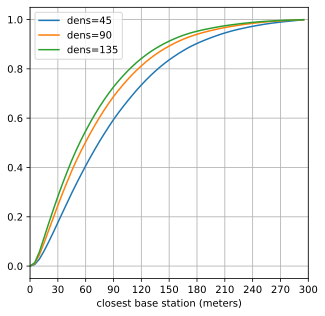

In [17]:
plt.figure(figsize=(5,5))
for ddx, dens in enumerate(sorted(map(int, results.dens.unique()))):
    ax = plt.subplot(1,1,1)
    y, bins = np.histogram(results[(results.scoring != '3-CM2') & (results.dens == dens)].min_distance, bins=60, range=(0,300))
    y=y/sum(y)
    ecdf = [sum(y[:i]) for i in range(len(y))]
    ax.plot(bins[:-1], ecdf, label=f'dens={dens}')
    ax.set_xticks(np.arange(0,330,30))
    ax.set_xlim([0,300])
    ax.grid()
plt.legend()
plt.xlabel('closest base station (meters)') 